In [24]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split

MODEL_PATH = "models/EfficientNetB0_v_clean_reboot_final.h5"  # update if different
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1000)              513000    
                                                                 
Total params: 3,426,856
Trainable params: 1,168,872
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
# --- Constants ---
CSV_PATH = "pokemoncards/TCG_labels_aug.csv"
MODEL_DIR = "models"
VERSION = "v_clean_reboot"
MODEL_TYPE = "EfficientNetB0"
BATCH_SIZE = 32
EPOCHS = 25
IMG_SIZE = (224, 224)
TOP_N_CLASSES = 1000
Shorten_data = True
# --- Prepare Dataset ---
df = pd.read_csv(CSV_PATH)
if Shorten_data:
    # Select top classes by frequency
    top_classes = df['label'].value_counts().head(TOP_N_CLASSES).index
    df = df[df['label'].isin(top_classes)].copy()

df['label_index'] = pd.factorize(df['label'])[0]

# Train/Val Split
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label_index'], random_state=42)

# TF Datasets
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image / 255.0, label
# --- TF Dataset Preparation ---
AUTOTUNE = tf.data.AUTOTUNE

def get_dataset(df):
    paths = df['path'].values
    labels = df['label_index'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    return ds

train_ds = get_dataset(train_df)
val_ds = get_dataset(val_df)

train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'].values, val_df['label_index'].values))
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)


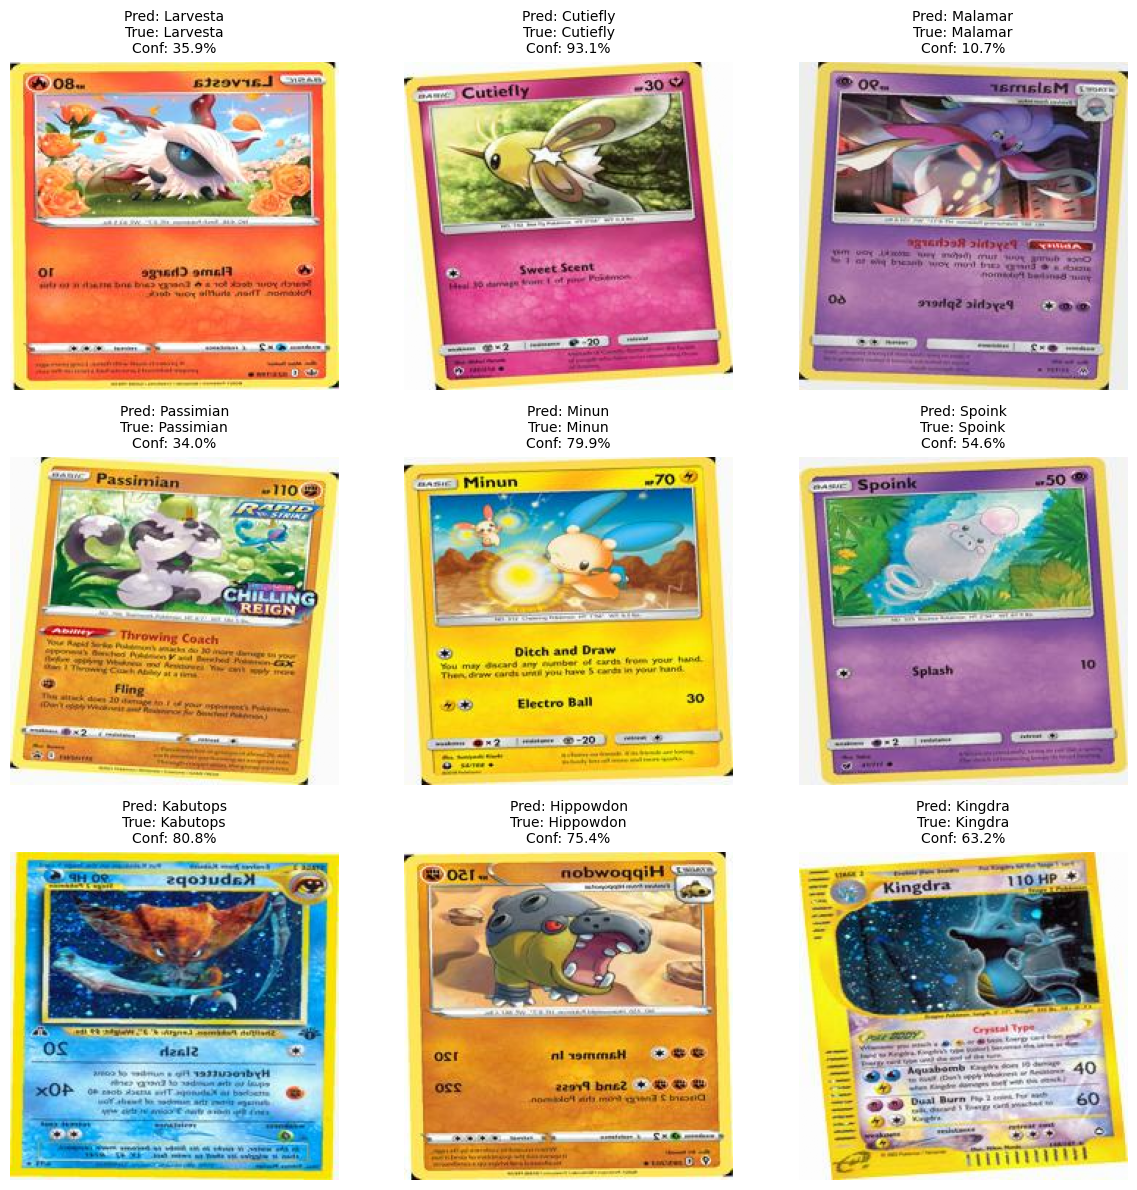

In [48]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Constants ---
CSV_PATH = "pokemoncards/augmented_metadata.csv"
ORIGINAL_LABELS_CSV = "pokemoncards/TCG_labels_aug.csv"
MODEL_PATH = "models/EfficientNetB0_v_clean_reboot_final.h5"
IMG_SIZE = (224, 224)
TOP_N_CLASSES = 1000

# --- Load original full label CSV for card name lookup ---
df_original = pd.read_csv(ORIGINAL_LABELS_CSV)

# --- Load and shorten training/val data to top N classes ---
df = pd.read_csv(CSV_PATH)
top_classes = df['label'].value_counts().head(TOP_N_CLASSES).index
df = df[df['label'].isin(top_classes)].copy()
df['label_index'] = pd.factorize(df['label'])[0]

# --- Create label map: index -> label ---
label_map = dict(zip(df['label_index'], df['label']))

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Image preprocessing ---
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image

# --- Get card name from label by looking in original CSV ---
def get_card_name(label, df_lookup):
    match = df_lookup[df_lookup['label'] == label]
    if not match.empty:
        filename = os.path.basename(match.iloc[0]['path'])  # e.g., ex12-1_Aerodactyl.jpg
        return os.path.splitext(filename)[0].split('_', 1)[-1]  # returns "Aerodactyl"
    else:
        return f"[Missing: {label}]"

# --- Sample 9 examples from the filtered 1000-class dataset ---
samples = df.sample(9, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 12))
for i, row in samples.iterrows():
    image_path = row['path']
    true_label = row['label']

    # Load and predict
    image = load_image(image_path)
    probs = model.predict(tf.expand_dims(image, 0), verbose=0)[0]
    pred_index = np.argmax(probs)
    pred_label = label_map[pred_index]
    confidence = np.max(probs)

    # Cross-reference for display names
    pred_name = get_card_name(pred_label, df_original)
    true_name = get_card_name(true_label, df_original)

    # Plot
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}\nConf: {confidence:.1%}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig("pokemon_predictions_grid.png", dpi=300)
plt.show()


In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
y_true = val_df['label_index'].values
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Report
print(classification_report(y_true, y_pred, zero_division=0))

79/79 [==============================] - 2s 20ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00    

pokemoncards/pokemon_card_images\base1-28_Growlithe.jpg


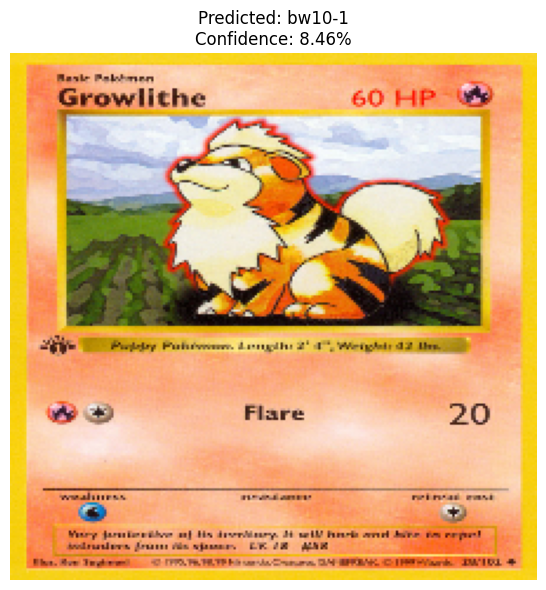

In [28]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Setup ---
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# --- Constants ---
CSV_PATH = "pokemoncards/TCG_labels_aug.csv"
MODEL_PATH = "models/EfficientNetB0_v_clean_reboot_final.h5"
IMAGE_DIR = "pokemoncards/pokemon_card_images"
IMG_SIZE = (224, 224)

# --- Load Model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Load Labels ---
df = pd.read_csv(CSV_PATH)
label_map = dict(zip(pd.factorize(df['label'])[0], df['label']))

# --- Select Image ---
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
selected_index = 19  # change if you want a different one
selected_image_path = os.path.join(IMAGE_DIR, image_files[selected_index])

# --- Preprocess Image ---
def load_image_for_prediction(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image

img = load_image_for_prediction(selected_image_path)
img_batch = tf.expand_dims(img, 0)

# --- Predict ---
probs = model.predict(img_batch, verbose=0)[0]
print(selected_image_path)
predicted_index = np.argmax(probs)
predicted_label = label_map[predicted_index]
confidence = np.max(probs)

# --- Display ---
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2%}")
plt.axis('off')
plt.tight_layout()
plt.savefig("sample_prediction.png", dpi=300)
plt.show()
